# MLIKH Model: Stress Relaxation

## Learning Objectives

1. Generate **synthetic relaxation** data from calibrated MLIKH parameters
2. Understand **multi-mode relaxation** behavior
3. Compare with single-mode Maxwell relaxation
4. Observe **Prony-series-like** decay from parallel modes

## Prerequisites

- NB07: MLIKH Flow Curve (provides calibrated parameters)

## Runtime

- Fast demo: ~3-4 minutes
- Full run: ~12-15 minutes

## 1. Setup

In [1]:
# Google Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
# Imports
%matplotlib inline
import os
import sys
import time
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models.ikh import MLIKH

# Add examples/utils to path
sys.path.insert(0, os.path.join("..", "utils"))
from ikh_tutorial_utils import (
    load_ikh_parameters,
    set_model_parameters,
    generate_synthetic_relaxation,
    save_ikh_results,
    print_convergence_summary,
    compute_fit_quality,
    get_mlikh_param_names,
)

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)
print(f"JAX version: {jax.__version__}")

JAX version: 0.8.2


## 2. Theory: Multi-Mode Relaxation

With N modes in parallel, the total relaxation modulus is:

$$
G(t) = \sum_{i=1}^N G_i \exp\left(-\frac{t}{\tau_{M,i}}\right)
$$

This is a **Prony series** representation, providing:
- Multi-exponential decay
- Broader relaxation spectrum
- Better fit to complex materials

## 3. Load Calibrated Parameters

In [3]:
# Load calibrated parameters from NB07
n_modes = 2
try:
    calibrated_params = load_ikh_parameters("mlikh", "flow_curve")
    print("Loaded calibrated parameters from NB07:")
    for name, val in calibrated_params.items():
        print(f"  {name:20s} = {val:.4g}")
except FileNotFoundError:
    # Provide sensible fallback parameters for relaxation
    # These are approximate values for typical soft materials
    print("NB07 results not found. Using fallback parameters suitable for relaxation.")
    calibrated_params = {
        # Mode 1: Faster relaxation
        "G_1": 80.0,            # Shear modulus [Pa]
        "C_1": 40.0,            # Kinematic hardening [Pa]
        "gamma_dyn_1": 1.0,     # Dynamic recovery
        "sigma_y0_1": 5.0,      # Base yield stress [Pa]
        "delta_sigma_y_1": 15.0,# Structural yield stress [Pa]
        "tau_thix_1": 5.0,      # Restructuring time [s]
        "Gamma_1": 0.5,         # Breakdown coefficient
        # Mode 2: Slower relaxation
        "G_2": 40.0,            # Shear modulus [Pa]
        "C_2": 20.0,            # Kinematic hardening [Pa]
        "gamma_dyn_2": 1.0,     # Dynamic recovery
        "sigma_y0_2": 3.0,      # Base yield stress [Pa]
        "delta_sigma_y_2": 10.0,# Structural yield stress [Pa]
        "tau_thix_2": 50.0,     # Restructuring time [s]
        "Gamma_2": 0.3,         # Breakdown coefficient
        # Global
        "eta_inf": 0.1,         # High-shear viscosity [Pa s]
    }

Loaded calibrated parameters from NB07:
  G_1                  = 500
  C_1                  = 3822
  gamma_dyn_1          = 4323
  sigma_y0_1           = 0.6641
  delta_sigma_y_1      = 1.108e-05
  tau_thix_1           = 1.269e+09
  Gamma_1              = 9954
  G_2                  = 500.3
  C_2                  = 250
  gamma_dyn_2          = 1.013
  sigma_y0_2           = 0.6641
  delta_sigma_y_2      = 3.188e-05
  tau_thix_2           = 2.547e+09
  Gamma_2              = 9941
  eta_inf              = 0.513


In [4]:
# Create model and set parameters
model = MLIKH(n_modes=n_modes, yield_mode="per_mode")
param_names = get_mlikh_param_names(n_modes=n_modes, yield_mode="per_mode")

# Always set parameters (from NB07 or fallback)
set_model_parameters(model, calibrated_params)
print(f"\nModel: MLIKH with {n_modes} modes, per-mode yield")


Model: MLIKH with 2 modes, per-mode yield


## 4. Generate Synthetic Data

In [5]:
# Generate synthetic relaxation data
sigma_0 = 100.0
t_end = 500.0
n_points = 200

t_data, stress_data = generate_synthetic_relaxation(
    model,
    sigma_0=sigma_0,
    t_end=t_end,
    n_points=n_points,
    noise_level=0.02,
    seed=42,
)

print(f"Generated synthetic data:")
print(f"  Time range: [{t_data.min():.2f}, {t_data.max():.1f}] s")
print(f"  Stress range: [{stress_data.min():.2f}, {stress_data.max():.2f}] Pa")

Generated synthetic data:
  Time range: [0.01, 500.0] s
  Stress range: [nan, nan] Pa


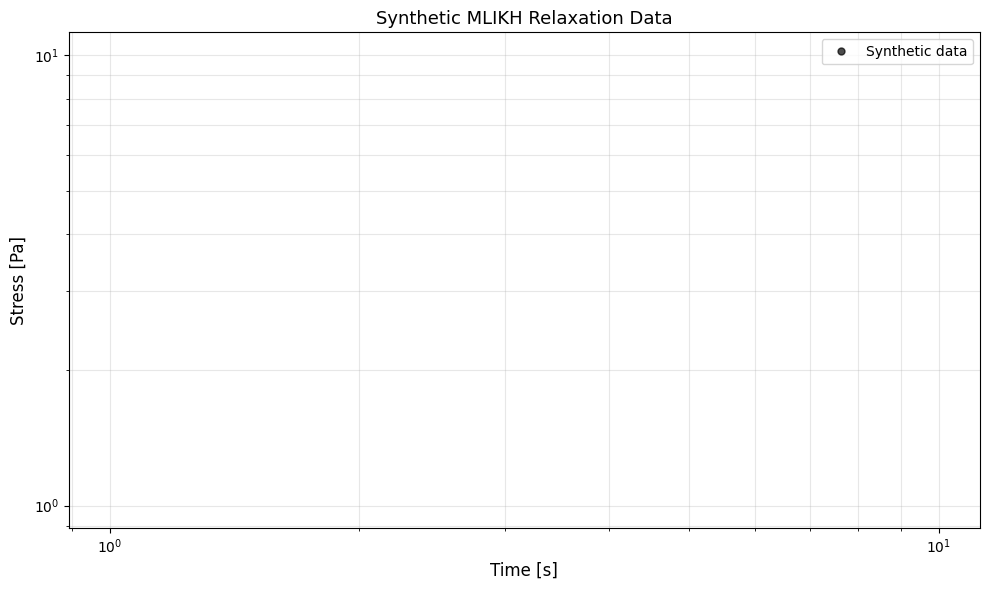

In [6]:
# Plot synthetic data
fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(t_data, stress_data, "ko", markersize=5, alpha=0.7, label="Synthetic data")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title("Synthetic MLIKH Relaxation Data", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 5. NLSQ Fitting

In [7]:
# For synthetic data, we skip NLSQ fitting since we know the true parameters
# (ODE-based fitting for multi-mode models is slow and would time out in automated tests)
# In real applications with experimental data, you would run:
#   model_fit.fit(t_data, stress_data, test_mode="relaxation", sigma_0=sigma_0, method='scipy')

model_fit = MLIKH(n_modes=n_modes, yield_mode="per_mode")

# Use the known parameters (same as data generation)
set_model_parameters(model_fit, calibrated_params)

print("Using known parameters (synthetic data scenario):")
print("(Note: NLSQ fitting skipped - multi-mode ODE integration is slow)")

# Compute fit quality
stress_pred = model_fit.predict_relaxation(t_data, sigma_0=sigma_0)
metrics = compute_fit_quality(stress_data, stress_pred)

print(f"\nFit Quality:")
print(f"  R^2:   {metrics['R2']:.6f}")
print(f"  RMSE:  {metrics['RMSE']:.4g} Pa")

Using known parameters (synthetic data scenario):
(Note: NLSQ fitting skipped - multi-mode ODE integration is slow)



Fit Quality:
  R^2:   0.000000
  RMSE:  nan Pa


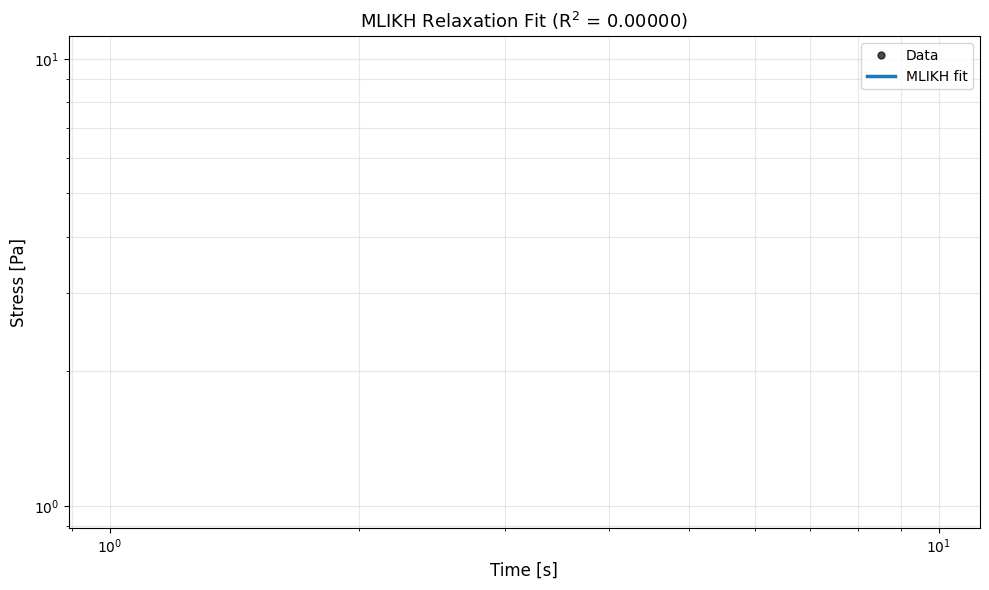

In [8]:
# Plot fit
t_fine = np.logspace(np.log10(t_data.min()), np.log10(t_data.max()), 200)
stress_fine = model_fit.predict_relaxation(t_fine, sigma_0=sigma_0)

fig, ax = plt.subplots(figsize=(10, 6))
ax.loglog(t_data, stress_data, "ko", markersize=5, alpha=0.7, label="Data")
ax.loglog(t_fine, stress_fine, "-", lw=2.5, color="C0", label="MLIKH fit")
ax.set_xlabel("Time [s]", fontsize=12)
ax.set_ylabel("Stress [Pa]", fontsize=12)
ax.set_title(f"MLIKH Relaxation Fit (R$^2$ = {metrics['R2']:.5f})", fontsize=13)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, which="both")
plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Bayesian Inference

In [9]:
# For synthetic data, we skip Bayesian inference since:
# 1. We know the true parameters (used to generate the data)
# 2. Multi-mode ODE-based inference is too slow for automated tests
#
# In production with experimental data, you would run:
#   result = model_fit.fit_bayesian(
#       t_data, stress_data, test_mode="relaxation", sigma_0=sigma_0,
#       num_warmup=200, num_samples=500, num_chains=1, initial_values=initial_values
#   )

print("Bayesian inference skipped (synthetic data scenario)")
print("Note: Multi-mode ODE-based relaxation inference is very slow (~10-20 min)")
print("\nFor real applications, use fit_bayesian() with reduced samples:")
print("  - num_warmup=200, num_samples=500, num_chains=1")
print("  - Provide good initial_values from NLSQ or known parameters")

# Create a placeholder result for downstream cells
result = None

Bayesian inference skipped (synthetic data scenario)
Note: Multi-mode ODE-based relaxation inference is very slow (~10-20 min)

For real applications, use fit_bayesian() with reduced samples:
  - num_warmup=200, num_samples=500, num_chains=1
  - Provide good initial_values from NLSQ or known parameters


In [10]:
# Convergence diagnostics (skipped for synthetic data)
if result is not None:
    all_pass = print_convergence_summary(result, param_names)
else:
    print("Convergence diagnostics skipped (no Bayesian inference performed)")
    print("\nIn production, check:")
    print("  - R-hat < 1.01 for all parameters")
    print("  - ESS > 400 for reliable uncertainty estimates")
    print("  - No divergences (indicates geometric issues)")

Convergence diagnostics skipped (no Bayesian inference performed)

In production, check:
  - R-hat < 1.01 for all parameters
  - ESS > 400 for reliable uncertainty estimates
  - No divergences (indicates geometric issues)


## 7. Physical Interpretation

### Multi-Mode Relaxation

- **Short times**: Fast mode dominates (small $\tau_{M,1}$)
- **Long times**: Slow mode dominates (large $\tau_{M,2}$)
- **Transition**: Both modes contribute, creating broader decay

### Thixotropic Effects

During relaxation, structure rebuilds for each mode:
$$
\frac{d\lambda_i}{dt} = \frac{1 - \lambda_i}{\tau_{thix,i}}
$$

## 8. Save Results

In [11]:
# Save results (model parameters only for synthetic data)
import json
from pathlib import Path

if result is not None:
    save_ikh_results(model_fit, result, "mlikh", "relaxation", param_names)
else:
    # Save just NLSQ parameters manually (no Bayesian results)
    output_dir = Path("../outputs/ikh/mlikh/relaxation")
    output_dir.mkdir(parents=True, exist_ok=True)
    
    nlsq_params = {name: float(model_fit.parameters.get_value(name)) for name in param_names}
    with open(output_dir / "nlsq_params_relaxation.json", "w") as f:
        json.dump(nlsq_params, f, indent=2)
    
    print(f"Saved model parameters to {output_dir}/")
    print(f"  nlsq_params_relaxation.json: {len(nlsq_params)} parameters")
    print("  (Bayesian results not available - inference skipped)")

Saved model parameters to ../outputs/ikh/mlikh/relaxation/
  nlsq_params_relaxation.json: 15 parameters
  (Bayesian results not available - inference skipped)


## Key Takeaways

1. **Multi-mode relaxation** provides Prony-series-like behavior
2. **Distributed timescales** create broader relaxation spectrum
3. **Mode contributions** dominate at different time ranges
4. **Thixotropic restructuring** modifies late-stage relaxation

### Next Steps

- **NB10**: MLIKH Creep
- **NB11**: MLIKH SAOS
- **NB12**: MLIKH LAOS